In [2]:
%cd /content/drive/MyDrive/KTH/course/gpu/hw4

/content/drive/MyDrive/KTH/course/gpu/hw4


In [4]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-oxd1_ds7
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-oxd1_ds7
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=b1ac6915e016374f5cb6cd6174493f413eea3a8e749f266a6b4f66d7e8b3e52e
  Stored in directory: /tmp/pip-ephem-wheel-cache-a7oxon4v/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [5]:
%load_ext nvcc_plugin

directory /content/drive/MyDrive/KTH/course/gpu/hw4/src already exists
Out bin /content/drive/MyDrive/KTH/course/gpu/hw4/result.out


In [6]:
%%cuda --name lab4_ex4.cu 
#include <cuda_runtime_api.h>
#include <math.h>
#include <stdlib.h>
#include <sys/time.h>
#include <cusparse_v2.h>
#include <cublas_v2.h>
#include <thrust/device_ptr.h>
#include <thrust/sequence.h>

#define gpuCheck(stmt)                                               \
  do {                                                               \
      cudaError_t err = stmt;                                        \
      if (err != cudaSuccess) {                                      \
          printf("ERROR. Failed to run stmt %s\n", #stmt);           \
          break;                                                     \
      }                                                              \
  } while (0)

// Macro to check the cuBLAS status
#define cublasCheck(stmt)                                            \
  do {                                                               \
      cublasStatus_t err = stmt;                                     \
      if (err != CUBLAS_STATUS_SUCCESS) {                            \
          printf("ERROR. Failed to run cuBLAS stmt %s\n", #stmt);    \
          break;                                                     \
      }                                                              \
  } while (0)

// Macro to check the cuSPARSE status
#define cusparseCheck(stmt)                                          \
  do {                                                               \
      cusparseStatus_t err = stmt;                                   \
      if (err != CUSPARSE_STATUS_SUCCESS) {                          \
          printf("ERROR. Failed to run cuSPARSE stmt %s\n", #stmt);  \
          break;                                                     \
      }                                                              \
  } while (0)


struct timeval t_start, t_end;
void cputimer_start(){
  gettimeofday(&t_start, 0);
}
void cputimer_stop(const char* info){
  gettimeofday(&t_end, 0);
  double time = (1000000.0*(t_end.tv_sec-t_start.tv_sec) + t_end.tv_usec-t_start.tv_usec);
  printf("Timing - %s. \t\tElasped %.0f microseconds \n", info, time);
}

// Initialize the sparse matrix needed for the heat time step
void matrixInit(double* A, int* ArowPtr, int* AcolIndx, int dimX,
    double alpha) {
  // Stencil from the finete difference discretization of the equation
  double stencil[] = { 1, -2, 1 };
  // Variable holding the position to insert a new element
  size_t ptr = 0;
  // Insert a row of zeros at the beginning of the matrix
  ArowPtr[1] = ptr;
  // Fill the non zero entries of the matrix
  for (int i = 1; i < (dimX - 1); ++i) {
    // Insert the elements: A[i][i-1], A[i][i], A[i][i+1]
    for (int k = 0; k < 3; ++k) {
      // Set the value for A[i][i+k-1]
      A[ptr] = stencil[k];
      // Set the column index for A[i][i+k-1]
      AcolIndx[ptr++] = i + k - 1;
    }
    // Set the number of newly added elements
    ArowPtr[i + 1] = ptr;
  }
  // Insert a row of zeros at the end of the matrix
  ArowPtr[dimX] = ptr;
}

int main(int argc, char **argv) {
  int device = 0;            // Device to be used
  int dimX;                  // Dimension of the metal rod
  int nsteps;                // Number of time steps to perform
  double alpha = 0.4;        // Diffusion coefficient
  double* temp;              // Array to store the final time step
  double* A;                 // Sparse matrix A values in the CSR format
  int* ARowPtr;              // Sparse matrix A row pointers in the CSR format
  int* AColIndx;             // Sparse matrix A col values in the CSR format
  int nzv;                   // Number of non zero values in the sparse matrix
  double* tmp;               // Temporal array of dimX for computations
  size_t bufferSize = 0;     // Buffer size needed by some routines
  void* buffer = nullptr;    // Buffer used by some routines in the libraries
  int concurrentAccessQ;     // Check if concurrent access flag is set
  double zero = 0;           // Zero constant
  double one = 1;            // One constant
  double norm;               // Variable for norm values
  double error;              // Variable for storing the relative error
  double tempLeft = 200.;    // Left heat source applied to the rod
  double tempRight = 300.;   // Right heat source applied to the rod
  cublasHandle_t cublasHandle;      // cuBLAS handle
  cusparseHandle_t cusparseHandle;  // cuSPARSE handle
  cusparseSpMatDescr_t Adescriptor;   // Mat descriptor needed by cuSPARSE

  // Read the arguments from the command line
  dimX = atoi(argv[1]);
  nsteps = atoi(argv[2]);

  // Print input arguments
  printf("The X dimension of the grid is %d \n", dimX);
  printf("The number of time steps to perform is %d \n", nsteps);

  // Get if the cudaDevAttrConcurrentManagedAccess flag is set
  gpuCheck(cudaDeviceGetAttribute(&concurrentAccessQ, cudaDevAttrConcurrentManagedAccess, device));
  // concurrentAccessQ = 0; //set prefetch or not 
  // Calculate the number of non zero values in the sparse matrix. This number
  // is known from the structure of the sparse matrix
  nzv = 3 * dimX - 6;

  //@@ Insert the code to allocate the temp, tmp and the sparse matrix
  //@@ arrays using Unified Memory
  cputimer_start();

  cudaMallocManaged(&A, (dimX)*sizeof(double));
  cudaMallocManaged(&tmp, (dimX)*sizeof(double));
  cudaMallocManaged(&temp, (dimX)*sizeof(double));
  cudaMallocManaged(&ARowPtr, (dimX)*sizeof(int));
  cudaMallocManaged(&AColIndx, (dimX)*sizeof(int));

  cputimer_stop("Allocating device memory");

  // Check if concurrentAccessQ is non zero in order to prefetch memory
  if (concurrentAccessQ) {
    cputimer_start();
    //@@ Insert code to prefetch in Unified Memory asynchronously to CPU
    cudaMemPrefetchAsync(A, (dimX)*sizeof(double), cudaCpuDeviceId, NULL);
    cudaMemPrefetchAsync(tmp, (dimX)*sizeof(double), cudaCpuDeviceId, NULL);
    cudaMemPrefetchAsync(temp, (dimX)*sizeof(double), cudaCpuDeviceId, NULL);
    cudaMemPrefetchAsync(ARowPtr, (dimX)*sizeof(int), cudaCpuDeviceId, NULL);
    cudaMemPrefetchAsync(AColIndx, (dimX)*sizeof(int), cudaCpuDeviceId, NULL);
    
    cputimer_stop("Prefetching GPU memory to the host");
  }
  // Initialize the sparse matrix
  cputimer_start();
  matrixInit(A, ARowPtr, AColIndx, dimX, alpha);
  cputimer_stop("Initializing the sparse matrix on the host");

  //Initiliaze the boundary conditions for the heat equation
  cputimer_start();
  memset(temp, 0, sizeof(double) * dimX);
  temp[0] = tempLeft;
  temp[dimX - 1] = tempRight;
  cputimer_stop("Initializing memory on the host");

  if (concurrentAccessQ) {
    cputimer_start();
    //@@ Insert code to prefetch in Unified Memory asynchronously to the GPU
    cudaMemPrefetchAsync(A, (dimX)*sizeof(double), device, NULL);
    cudaMemPrefetchAsync(tmp, (dimX)*sizeof(double), device, NULL);
    cudaMemPrefetchAsync(temp, (dimX)*sizeof(double), device, NULL);
    cudaMemPrefetchAsync(ARowPtr, (dimX)*sizeof(int), device, NULL);
    cudaMemPrefetchAsync(AColIndx, (dimX)*sizeof(int), device, NULL);

    cputimer_stop("Prefetching GPU memory to the device");
  }

  //@@ Insert code to create the cuBLAS handle
  cublasCreate(&cublasHandle);
  //@@ Insert code to create the cuSPARSE handle
  cusparseCreate(&cusparseHandle);
  //@@ Insert code to set the cuBLAS pointer mode to CUSPARSE_POINTER_MODE_HOST
  cusparseSetPointerMode(cusparseHandle, CUSPARSE_POINTER_MODE_HOST);
  //@@ Insert code to call cusparse api to create the mat descriptor used by cuSPARSE
  Adescriptor = NULL;
  cusparseCreateMatDescr((cusparseMatDescr_t *)&Adescriptor);
  cusparseSetMatType((cusparseMatDescr_t)Adescriptor, CUSPARSE_MATRIX_TYPE_GENERAL);
  cusparseSetMatIndexBase((cusparseMatDescr_t)Adescriptor, CUSPARSE_INDEX_BASE_ZERO);
  //@@ Insert code to call cusparse api to get the buffer size needed by the sparse matrix per
  //@@ vector (SMPV) CSR routine of cuSPARSE
  cusparseCreateCsr(&Adescriptor, dimX, dimX, nzv,
                    ARowPtr, AColIndx, A,
                    CUSPARSE_INDEX_32I, CUSPARSE_INDEX_32I,
                    CUSPARSE_INDEX_BASE_ZERO, CUDA_R_32F);
  cusparseDnVecDescr_t vecx = NULL;
  cusparseCreateDnVec(&vecx, dimX, temp, CUDA_R_32F);
  cusparseDnVecDescr_t vecAx = NULL;
  cusparseCreateDnVec(&vecAx, dimX, tmp, CUDA_R_32F);
  //@@ Insert code to allocate the buffer needed by cuSPARSE
  cusparseSpMV_bufferSize(
        cusparseHandle, CUSPARSE_OPERATION_NON_TRANSPOSE, &alpha, Adescriptor, vecx, &one, vecAx, CUDA_R_32F, CUSPARSE_SPMV_ALG_DEFAULT, &bufferSize);
  // Perform the time step iterations
  for (int it = 0; it < nsteps; ++it) {
    //@@ Insert code to call cusparse api to compute the SMPV (sparse matrix multiplication) for
    //@@ the CSR matrix using cuSPARSE. This calculation corresponds to:
    //@@ tmp = 1 * A * temp + 0 * tmp
    if (it == 0)
      cputimer_start();
    cusparseSpMV(cusparseHandle,
             CUSPARSE_OPERATION_NON_TRANSPOSE,
             &one,
             Adescriptor,
             vecx,
             &zero,
             vecAx,
             CUDA_R_32F,
             CUSPARSE_SPMV_ALG_DEFAULT,
             &bufferSize);
    
    //@@ Insert code to call cublas api to compute the axpy routine using cuBLAS.
    //@@ This calculation corresponds to: temp = alpha * tmp + temp
    cublasDaxpy(cublasHandle, dimX, &alpha, tmp, one, temp, one);
    if (it == 0)
      cputimer_stop("SpMV time:");
    //@@ Insert code to call cublas api to compute the norm of the vector using cuBLAS
    //@@ This calculation corresponds to: ||temp||
    cublasDnrm2(cublasHandle, dimX, temp, one, &norm);
    // If the norm of A*temp is smaller than 10^-4 exit the loop
    if (norm < 1e-4)
      break;
  }

  // Calculate the exact solution using thrust
  thrust::device_ptr<double> thrustPtr(tmp);
  thrust::sequence(thrustPtr, thrustPtr + dimX, tempLeft,
      (tempRight - tempLeft) / (dimX - 1));
  // Calculate the relative approximation error:
  one = -1;
  //@@ Insert the code to call cublas api to compute the difference between the exact solution
  //@@ and the approximation
  //@@ This calculation corresponds to: tmp = -temp + tmp
  cublasDaxpy(cublasHandle, dimX, &one, temp, 1, tmp, 1);
  //@@ Insert the code to call cublas api to compute the norm of the absolute error
  //@@ This calculation corresponds to: || tmp ||
  cublasDnrm2(cublasHandle, dimX, tmp, 1, &norm);
  error = norm;
  //@@ Insert the code to call cublas api to compute the norm of temp
  //@@ This calculation corresponds to: || temp ||
  cublasDnrm2(cublasHandle, dimX, temp, 1, &norm);
  // Calculate the relative error
  error = error / norm;
  printf("The relative error of the approximation is %f\n", error);

  //@@ Insert the code to destroy the mat descriptor
  cusparseDestroySpMat(Adescriptor);
  //@@ Insert the code to destroy the cuSPARSE handle
  cusparseDestroy(cusparseHandle);
  //@@ Insert the code to destroy the cuBLAS handle
  cublasDestroy(cublasHandle);

  cusparseDestroyDnVec(vecx);
  cusparseDestroyDnVec(vecAx);


  //@@ Insert the code for deallocating memory
  cudaFree(temp);
  cudaFree(A);
  cudaFree(ARowPtr);
  cudaFree(AColIndx);
  cudaFree(tmp);
  free(buffer); 


  return 0;
}

'File written in /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4.cu'

In [7]:
!nvcc -o /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4.cu -lcublas -lcusparse

In [6]:
! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 4096 10000

The X dimension of the grid is 4096 
The number of time steps to perform is 10000 
Timing - Allocating device memory. 		Elasped 264387 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 155 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 113 microseconds 
Timing - Initializing memory on the host. 		Elasped 1 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 403 microseconds 
Timing - SpMV time:. 		Elasped 46 microseconds 
The relative error of the approximation is 1.001993


In [7]:
%%shell 
#!/bin/bash
for VARIABLE in 64 128 256 512 1024 2048 4096
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 $VARIABLE 1000
done

The X dimension of the grid is 64 
The number of time steps to perform is 1000 
Timing - Allocating device memory. 		Elasped 184548 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 78 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 1 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 250 microseconds 
Timing - SpMV time:. 		Elasped 50 microseconds 
The relative error of the approximation is 1.183901
The X dimension of the grid is 128 
The number of time steps to perform is 1000 
Timing - Allocating device memory. 		Elasped 181656 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 48 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 33 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 303 microseconds 
Timing - SpMV time

CalledProcessError: ignored

In [ ]:
%%shell 
#!/bin/bash
for VARIABLE in 100 500 1000 5000 10000
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 $VARIABLE
done

The X dimension of the grid is 128 
The number of time steps to perform is 100 
Timing - Allocating device memory. 		Elasped 93112 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 53 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 38 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 233 microseconds 
The relative error of the approximation is 4.785882
The X dimension of the grid is 128 
The number of time steps to perform is 500 
Timing - Allocating device memory. 		Elasped 101053 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 85 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 34 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 217 microseconds 
The relative error of the approximation is 1.565238
The X dimension

CalledProcessError: ignored

Text(0, 0.5, 'The relative error')

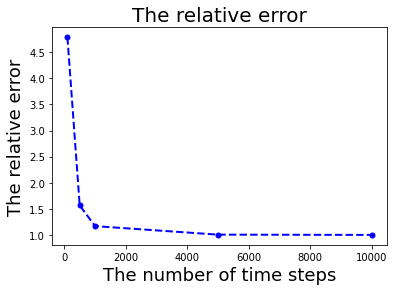

In [ ]:
import matplotlib.pyplot as plt

plt.plot([100, 500, 1000, 5000, 10000],[4.785882, 1.565238, 1.169500, 1.006505, 1.001338], 'bo--', linewidth=2, markersize=5)
plt.title('The relative error', fontsize=20)
plt.xlabel('The number of time steps', fontsize=18)
plt.ylabel('The relative error', fontsize=18)

without prefetch

In [ ]:
%%shell 
#!/bin/bash
for VARIABLE in 100 500 1000 5000 10000
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 $VARIABLE
done

The X dimension of the grid is 128 
The number of time steps to perform is 100 
Timing - Allocating device memory. 		Elasped 163387 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 47 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
The relative error of the approximation is 4.785882
The X dimension of the grid is 128 
The number of time steps to perform is 500 
Timing - Allocating device memory. 		Elasped 89373 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 49 microseconds 
Timing - Initializing memory on the host. 		Elasped 1 microseconds 
The relative error of the approximation is 1.565238
The X dimension of the grid is 128 
The number of time steps to perform is 1000 
Timing - Allocating device memory. 		Elasped 93198 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 49 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
The relative er

CalledProcessError: ignored

In [16]:
%%shell 
#!/bin/bash
for VARIABLE in 100 500 1000 5000 10000
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 $VARIABLE
done

The X dimension of the grid is 128 
The number of time steps to perform is 100 
Timing - Allocating device memory. 		Elasped 269982 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 58 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 36 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 478 microseconds 
Timing - SpMV time:. 		Elasped 42 microseconds 
The relative error of the approximation is 4.785882
The X dimension of the grid is 128 
The number of time steps to perform is 500 
Timing - Allocating device memory. 		Elasped 184512 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 42 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 33 microseconds 
Timing - Initializing memory on the host. 		Elasped 1 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 289 microseconds 
Timing - SpMV time

CalledProcessError: ignored

In [ ]:
%%shell 
#!/bin/bash
for VARIABLE in 128 512 2048 8152 32608
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 $VARIABLE 1000
done

With prefetch

In [9]:
%%shell 
#!/bin/bash
for VARIABLE in 100 500 1000 5000 10000
do
    nvprof /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 $VARIABLE
done

The X dimension of the grid is 128 
The number of time steps to perform is 100 
==1756== NVPROF is profiling process 1756, command: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 100
Timing - Allocating device memory. 		Elasped 324321 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 60 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 49 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 208 microseconds 
Timing - SpMV time:. 		Elasped 72 microseconds 
The relative error of the approximation is 4.785882
==1756== Profiling application: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 100
==1756== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   88.70%  9.5899ms       204  47.009us  43.711us  50.784us  void nrm2_kernel<double, double, double, int=0, int=0, int=128>

In [13]:
%%shell 
#!/bin/bash
for VARIABLE in 128 512 2048 8152 32608 55000
do
    nvprof /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 $VARIABLE 1000
done

The X dimension of the grid is 128 
The number of time steps to perform is 1000 
==3799== NVPROF is profiling process 3799, command: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 1000
Timing - Allocating device memory. 		Elasped 314685 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 65 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 41 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 338 microseconds 
Timing - SpMV time:. 		Elasped 69 microseconds 
The relative error of the approximation is 1.169500
==3799== Profiling application: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 1000
==3799== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   88.52%  91.307ms      2004  45.562us  36.031us  50.975us  void nrm2_kernel<double, double, double, int=0, int=0, int=1

CalledProcessError: ignored

Without prefetch

In [12]:
%%shell 
#!/bin/bash
for VARIABLE in 100 500 1000 5000 10000
do
    nvprof /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 $VARIABLE
done

The X dimension of the grid is 128 
The number of time steps to perform is 100 
==2825== NVPROF is profiling process 2825, command: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 100
Timing - Allocating device memory. 		Elasped 388329 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 65 microseconds 
Timing - Initializing memory on the host. 		Elasped 1 microseconds 
Timing - SpMV time:. 		Elasped 128 microseconds 
The relative error of the approximation is 4.785882
==2825== Profiling application: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 100
==2825== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   86.05%  9.5880ms       204  47.000us  43.871us  51.200us  void nrm2_kernel<double, double, double, int=0, int=0, int=128>(cublasNrm2Params<double, double>)
                    6.62%  738.04us       100  7.3800us  3.9360us  337.66us  void cusparse::vector_scalar_multi

In [13]:
%%shell 
#!/bin/bash
for VARIABLE in 128 512 2048 8152 32608
do
    nvprof /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 $VARIABLE 1000
done

The X dimension of the grid is 128 
The number of time steps to perform is 1000 
==3819== NVPROF is profiling process 3819, command: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 1000
Timing - Allocating device memory. 		Elasped 327868 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 78 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - SpMV time:. 		Elasped 140 microseconds 
The relative error of the approximation is 1.169500
==3819== Profiling application: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex4 128 1000
==3819== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   88.31%  94.236ms      2004  47.024us  43.744us  51.199us  void nrm2_kernel<double, double, double, int=0, int=0, int=128>(cublasNrm2Params<double, double>)
                    4.54%  4.8473ms      1001  4.8420us  4.7360us  10.720us  void axpy_kernel_val<double, do